# Import Libraries

In [203]:
# for drive access
from google.colab import drive
drive.mount('/content/drive')

# standard libraries
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load training csv & visualize total duration by species

In [204]:
df = pd.read_csv('/content/drive/MyDrive/project/clean_train_df_w_npy.csv')

df.head()

,primary_label,type,latitude,longitude,rating,filename,duration,country,continent,filename_npy
0,comsan,call,50.7542,4.5672,4.0,comsan/XC587730.ogg,5.746937,BE,EUROPE,comsan/XC587730.npy
1,eaywag1,call,69.3585,88.2378,3.0,eaywag1/XC675944.ogg,5.355000,RU,EUROPE,eaywag1/XC675944.npy
2,comsan,call,41.1698,0.9761,5.0,comsan/XC664012.ogg,10.488000,ES,EUROPE,comsan/XC664012.npy
3,barswa,call,NaN,NaN,2.5,barswa/XC268804.ogg,76.538813,UNKNOWN,UNKNOWN,barswa/XC268804.npy
4,barswa,song,53.9299,-2.9833,2.5,barswa/XC690498.ogg,83.095500,GB,EUROPE,barswa/XC690498.npy


In [205]:
colors = [
      '#ffa15a'
      ,'#636efa'
      ,'#ef553b'
  ]

In [206]:
duration_sum = df[['primary_label', 'duration']].groupby('primary_label').sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,primary_label,duration,duration_mins
2,eaywag1,11568.778688,192.812978
1,comsan,10923.561750,182.059363
0,barswa,12535.445813,208.924097


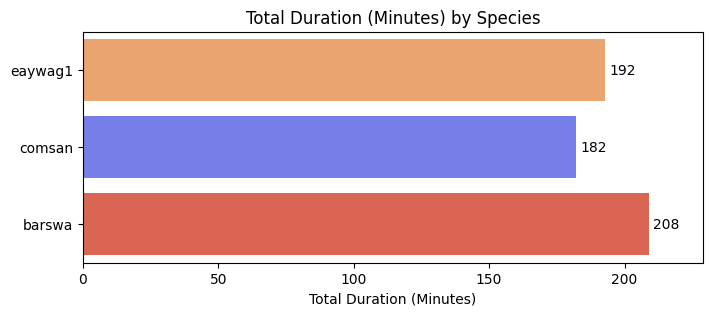

In [207]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,3))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum, palette=colors, ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum['duration_mins']) + 20])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species')

plt.show()

# Undersample the oversampled classes for the training set so the three classes are balanced during training

In [208]:
# find out the maximum total duration for each species in the training set
train_duration_max = np.min(duration_sum['duration'])*0.7

train_duration_max

7646.493225

In [209]:
# shuffle the original df before splitting to train/val
shuffled_df = df.sample(frac=1, random_state=1)

shuffled_df.head()

,primary_label,type,latitude,longitude,rating,filename,duration,country,continent,filename_npy
550,comsan,call,48.0372,-4.8622,4.0,comsan/XC588564.ogg,29.570625,FR,EUROPE,comsan/XC588564.npy
78,eaywag1,call,51.4812,-9.7785,3.0,eaywag1/XC687206.ogg,152.633000,IE,EUROPE,eaywag1/XC687206.npy
335,eaywag1,call,66.5187,66.6791,2.5,eaywag1/XC675596.ogg,30.406000,RU,EUROPE,eaywag1/XC675596.npy
708,eaywag1,call,53.5001,22.7334,4.0,eaywag1/XC25496.ogg,24.241625,PL,EUROPE,eaywag1/XC25496.npy
99,eaywag1,call,69.3253,87.3168,4.0,eaywag1/XC675935.ogg,16.666000,RU,EUROPE,eaywag1/XC675935.npy


In [210]:
# draw samples from the df until the total duration for each species reaches the train_duration_max
train_df = pd.DataFrame()

for species in shuffled_df['primary_label'].unique():
  species_df = shuffled_df[shuffled_df['primary_label'] == species].copy()
  duration = 0

  while duration <= train_duration_max:
    sample = species_df.sample(n=1, replace=False, random_state=1)
    species_df.drop(sample.index, inplace=True)
    duration += sample['duration'].item()
    train_df = pd.concat([train_df, sample])

train_df.head()

,primary_label,type,latitude,longitude,rating,filename,duration,country,continent,filename_npy
885,comsan,call,51.9612,5.8104,2.0,comsan/XC528482.ogg,18.233500,NL,EUROPE,comsan/XC528482.npy
214,comsan,call,51.4522,-9.8189,4.0,comsan/XC667665.ogg,6.556000,IE,EUROPE,comsan/XC667665.npy
551,comsan,call,49.4452,22.6154,4.0,comsan/XC578772.ogg,31.268563,PL,EUROPE,comsan/XC578772.npy
754,comsan,blank,53.9299,-2.9833,2.5,comsan/XC702785.ogg,55.431875,GB,EUROPE,comsan/XC702785.npy
579,comsan,call,37.1379,-7.6303,3.0,comsan/XC494789.ogg,5.760000,PT,EUROPE,comsan/XC494789.npy


In [211]:
train_df['primary_label'].value_counts()

eaywag1    231
comsan     224
barswa     216
Name: primary_label, dtype: int64

In [212]:
train_df[['primary_label', 'duration']].groupby('primary_label').sum('duration')

,duration
primary_label,
barswa,7677.484562
comsan,7659.472937
eaywag1,7717.387062


# The samples not selected for training set are put into validation set

In [213]:
val_df = df.drop(train_df.index)

val_df.head()

,primary_label,type,latitude,longitude,rating,filename,duration,country,continent,filename_npy
2,comsan,call,41.1698,0.9761,5.0,comsan/XC664012.ogg,10.488000,ES,EUROPE,comsan/XC664012.npy
3,barswa,call,NaN,NaN,2.5,barswa/XC268804.ogg,76.538813,UNKNOWN,UNKNOWN,barswa/XC268804.npy
4,barswa,song,53.9299,-2.9833,2.5,barswa/XC690498.ogg,83.095500,GB,EUROPE,barswa/XC690498.npy
5,barswa,both,19.2561,-103.6886,5.0,barswa/XC317544.ogg,28.708562,MX,AMERICAS,barswa/XC317544.npy
6,comsan,call,63.8313,20.2607,5.0,comsan/XC430800.ogg,8.616000,SE,EUROPE,comsan/XC430800.npy


In [214]:
val_df['primary_label'].value_counts()

comsan     128
barswa     125
eaywag1    120
Name: primary_label, dtype: int64

In [215]:
val_df[['primary_label', 'duration']].groupby('primary_label').sum('duration')

,duration
primary_label,
barswa,4857.961250
comsan,3264.088813
eaywag1,3851.391625


# Confirm no duplicates and the samples in validation set are not in the training set

In [216]:
# to confirm there are no duplicates in training set
assert len(train_df) == train_df['filename_npy'].nunique()

In [217]:
# to confirm there are no duplicates in validation set
assert len(val_df) == val_df['filename_npy'].nunique()

In [218]:
# to confirm data in validation are not in training
is_present = val_df.isin(train_df).any().any()

assert not is_present

# Combine the train and val sets to one set with a column identifying the set the samples belong to

In [219]:
train_df['set'] = 'train'
val_df['set'] = 'val'

In [220]:
combined_df = pd.concat([train_df, val_df])

combined_df.head()

,primary_label,type,latitude,longitude,rating,filename,duration,country,continent,filename_npy,set
885,comsan,call,51.9612,5.8104,2.0,comsan/XC528482.ogg,18.233500,NL,EUROPE,comsan/XC528482.npy,train
214,comsan,call,51.4522,-9.8189,4.0,comsan/XC667665.ogg,6.556000,IE,EUROPE,comsan/XC667665.npy,train
551,comsan,call,49.4452,22.6154,4.0,comsan/XC578772.ogg,31.268563,PL,EUROPE,comsan/XC578772.npy,train
754,comsan,blank,53.9299,-2.9833,2.5,comsan/XC702785.ogg,55.431875,GB,EUROPE,comsan/XC702785.npy,train
579,comsan,call,37.1379,-7.6303,3.0,comsan/XC494789.ogg,5.760000,PT,EUROPE,comsan/XC494789.npy,train


In [221]:
duration_sum = combined_df[['primary_label', 'duration', 'set']].groupby(['set', 'primary_label']).sum('duration').reset_index().sort_values('primary_label', ascending=False)
duration_sum['duration_mins'] = duration_sum['duration'] / 60

duration_sum

,set,primary_label,duration,duration_mins
2,train,eaywag1,7717.387062,128.623118
5,val,eaywag1,3851.391625,64.189860
1,train,comsan,7659.472937,127.657882
4,val,comsan,3264.088813,54.401480
0,train,barswa,7677.484562,127.958076
3,val,barswa,4857.961250,80.966021


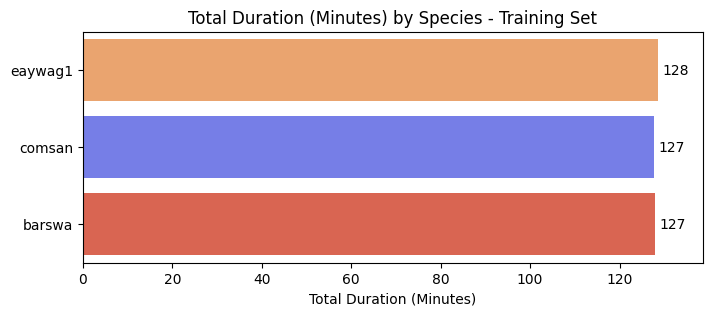

In [222]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,3))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='train'], palette=colors, ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='train']['duration_mins']) + 10])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Training Set')

plt.show()

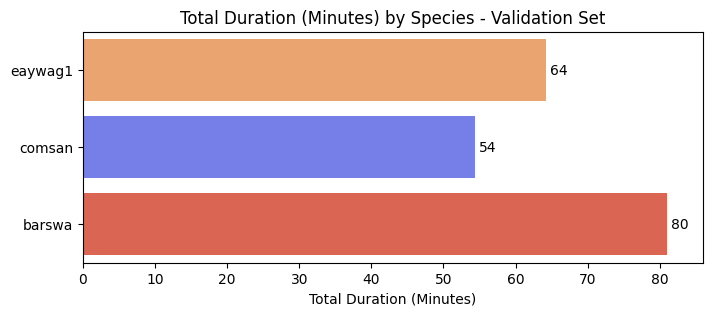

In [223]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,3))

sns.barplot(x='duration_mins', y='primary_label', data=duration_sum[duration_sum['set'] =='val'], palette=colors, ax=axes)
axes.bar_label(axes.containers[0], fmt='%i', padding=3)
axes.set(xlim=[0, np.max(duration_sum[duration_sum['set'] =='val']['duration_mins']) + 5])
axes.set(ylabel='')
axes.set(xlabel='Total Duration (Minutes)')
axes.set(title='Total Duration (Minutes) by Species - Validation Set')

plt.show()

# save the combined df to csv

In [224]:
combined_df.to_csv('/content/drive/MyDrive/project/train_val.csv', index=False)